(examples)=

# Examples

In [1]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 12
rcParams["legend.frameon"] = False
rcParams["lines.markersize"] = 10

import warnings
warnings.filterwarnings('ignore')

We collected some more in-depth examples below that demonstrate all features of riccati.

## Quick summary of the algorithm

The riccati solver solves ODEs whose solution may vary between oscillatory and slowly varying inside the solution interval. It does this by automatically switching between two methods: in oscillatory regions, an asymptotic series is computed to approximate the solution; in regions of few to no oscillations, a Chebyshev-grid-based collocation method is used. For more details, see our [paper](https://arxiv.org/abs/2212.06924).

In the examples below, we'll refer to the two types of steps as **Riccati** and **Chebyshev**.

## Optional and tuning parameters

In this section, we'll go through each optional (keyword-) parameter the riccati solver accepts.

### Tolerances

There are two tolerances the user can set. 

The first, `eps`, controls the relative local error. In both Riccati and Chebyshev steps, the step is accepted only if its estimated error is less than or equal to `eps`. 

The other, `epsh`, only affects Riccati steps. It is not used within the step, rather, to determine what size of step is possible with an asymptotic approximation. For small values of `eps`, small values of `epsh` are necessary, otherwise too large stepsizes may be chosen for Riccati steps to reach an error (residual) of `eps`.

We show a low, an intermediate, and a large tolerance example below on the equation 

$$ u'' + \frac{m^2 - 1}{(1 + t^2)^2} = 0, $$

with $m = 1000$, solved on $t \in [-m, m]$ and subject to initial conditions $u(-m) = \tilde{u}(-m)$, $u'(-m) = \tilde{u}'(-m)$, where $\tilde{u}$ is the analytic solution:

$$ \tilde{u}(t) = \frac{\sqrt{1 + t^2}}{m} e^{i m \arctan(t)}.$$

In [17]:
import numpy as np
import riccati

# Set up the ODE
m = 1000
w = lambda t: np.sqrt(m**2 - 1)/(1 + t**2)
g = lambda t: np.zeros_like(t)

# Analytic solution
y_ana = lambda t: np.sqrt(1 + t**2)/m*(np.cos(m*np.arctan(t)) + 1j*np.sin(m*np.arctan(t)))
dy_ana = lambda t: 1/np.sqrt(1 + t**2)/m*((t + 1j*m)*np.cos(m*np.arctan(t))\
                                          + (-m + 1j*t)*np.sin(m*np.arctan(t)))
                                

# Specify integration range and i.c.
ti = -m
tf = m
yi = y_ana(ti)
dyi = dy_ana(ti)

# Set up solver
info = riccati.solversetup(w, g)

In [26]:
# High tolerance
eps = 1e-4
epsh = 1e-5
ts_high, ys_high, *misc_high = riccati.solve(info, ti, tf, yi, dyi, eps = eps, epsh = epsh)

# Intermediate tolerance
eps = 1e-8
epsh = 1e-12
ts_inter, ys_inter, *misc_inter = riccati.solve(info, ti, tf, yi, dyi, eps = eps, epsh = epsh)

# Low tolerance
eps = 1e-12
epsh = 1e-13
ts_low, ys_low, *misc_low = riccati.solve(info, ti, tf, yi, dyi, eps = eps, epsh = epsh)

# Compute numerical errors
y_ana_high = y_ana(np.array(ts_high))
y_ana_inter = y_ana(np.array(ts_inter))
y_ana_low = y_ana(np.array(ts_low))
err_high = np.abs((ys_high - y_ana_high)/y_ana_high)
err_inter = np.abs((ys_inter - y_ana_inter)/y_ana_inter)
err_low = np.abs((ys_low - y_ana_low)/y_ana_low)

Now let's compare the numerical error with the different tolerance settings:

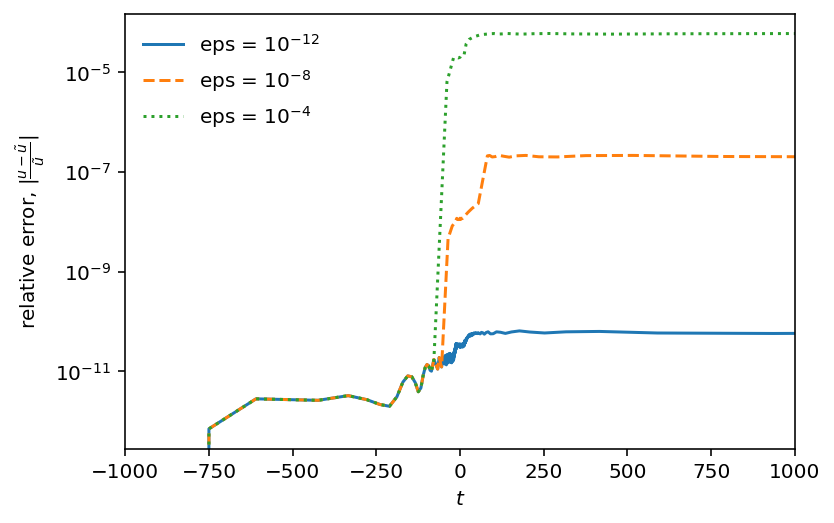

In [27]:
from matplotlib import pyplot as plt

plt.figure()
plt.semilogy(ts_low, err_low, label = "eps = $10^{-12}$")
plt.semilogy(ts_inter, err_inter, '--', label = "eps = $10^{-8}$")
plt.semilogy(ts_high, err_high, ls = 'dotted', label = "eps = $10^{-4}$")
plt.xlim(-m, m)
plt.xlabel('$t$')
plt.ylabel('relative error, $|\\frac{u - \\tilde{u}}{\\tilde{u}}|$')
plt.legend()
plt.show()

Let's see what happens in the extreme case of `epsh` > `eps`:

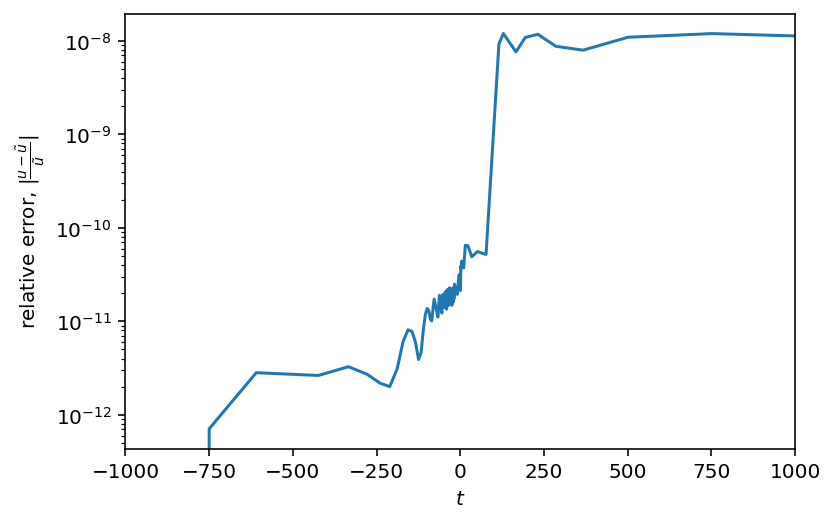

In [38]:
# Low eps, high epsh
eps = 1e-10
epsh = 1e-8
ts_weird, ys_weird, *misc_weird = riccati.solve(info, ti, tf, yi, dyi, eps = eps, epsh = epsh)

# Calculate numerical error
y_ana_weird = y_ana(np.array(ts_weird))
err_weird = np.abs((ys_weird - y_ana_weird)/y_ana_weird)

# Plot
plt.figure()
plt.semilogy(ts_weird, err_weird)
plt.xlim(-m, m)
plt.xlabel('$t$')
plt.ylabel('relative error, $|\\frac{u - \\tilde{u}}{\\tilde{u}}|$')
plt.show()

Uh-oh, we didn't get the required relative error because `epsh` was too large. As a rule of thumb, start with `epsh` = `eps`/10, then explore lower values to see if your solution has converged. Using the rule of thumb we get the desired error:

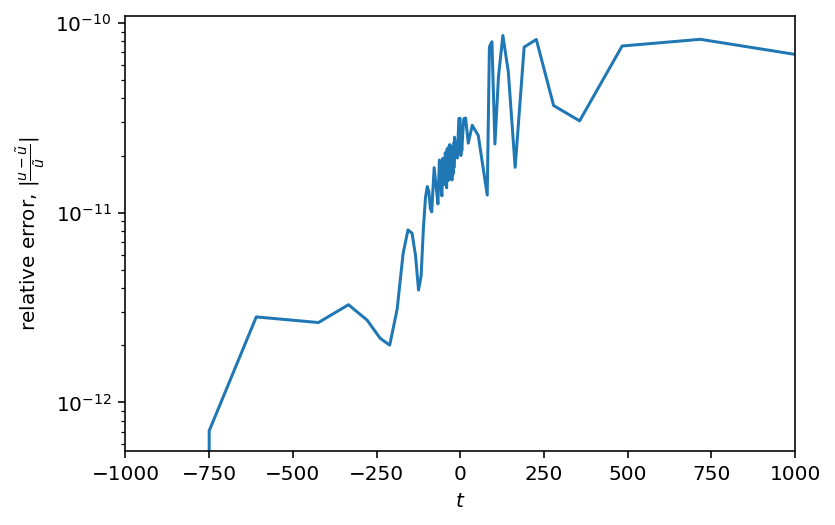

In [39]:
# Low eps, appropriate epsh
eps = 1e-10
epsh = 1e-11
ts_weird, ys_weird, *misc_weird = riccati.solve(info, ti, tf, yi, dyi, eps = eps, epsh = epsh)

# Calculate numerical error
y_ana_weird = y_ana(np.array(ts_weird))
err_weird = np.abs((ys_weird - y_ana_weird)/y_ana_weird)

# Plot
plt.figure()
plt.semilogy(ts_weird, err_weird)
plt.xlim(-m, m)
plt.xlabel('$t$')
plt.ylabel('relative error, $|\\frac{u - \\tilde{u}}{\\tilde{u}}|$')
plt.show()

### Hard stopping

hard_stop

### Number of collocation points

n, p, nini, nmax

### Initial stepsize

h0

## Solving an ODE one step at a time

### Single step

osc_step, nonosc_step

### Several steps within an interval

osc_evolve, nonosc_evolve